# 1. Import Libraries

In [2]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt
import warnings

# 2. Display Settings

In [3]:
pd.set_option("display.max_columns", None)


In [4]:
sklearn.set_config(transform_output="pandas")


In [5]:
warnings.filterwarnings("ignore")


# 3. Read the Data

In [6]:
path = r"C:\Users\HP\Desktop\Flight Price Prediction\Data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-27,Delhi,Cochin,08:55:00,15:30:00,395,1.0,No Info,7845
1,Multiple Carriers,2019-05-27,Delhi,Cochin,08:00:00,19:15:00,675,1.0,In-flight meal not included,11761
2,Jet Airways,2019-04-01,Kolkata,Banglore,20:00:00,23:35:00,1655,1.0,No Info,12681
3,Jet Airways,2019-03-06,Banglore,New Delhi,08:55:00,09:30:00,1475,1.0,No Info,17261
4,Jet Airways,2019-05-21,Kolkata,Banglore,10:20:00,17:35:00,435,1.0,In-flight meal not included,5608
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-06-12,Delhi,Cochin,09:00:00,19:00:00,600,1.0,In-flight meal not included,10262
636,Jet Airways,2019-03-06,Banglore,New Delhi,14:05:00,21:20:00,435,1.0,No Info,19225
637,Multiple Carriers,2019-06-03,Delhi,Cochin,10:35:00,19:00:00,505,1.0,No Info,10877
638,Air India,2019-03-03,Delhi,Cochin,05:55:00,07:40:00,1545,2.0,No Info,15428


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

# 4. Transformation Operations

In [9]:
# 4.1 airline

X_train.airline


0      Multiple Carriers
1      Multiple Carriers
2            Jet Airways
3            Jet Airways
4            Jet Airways
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638            Air India
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,0.0,1.0,0.0
638,1.0,0.0,0.0,0.0,0.0


In [11]:
# 4.2 date_of_journey

X_train.date_of_journey

0      2019-03-27
1      2019-05-27
2      2019-04-01
3      2019-03-06
4      2019-05-21
          ...    
635    2019-06-12
636    2019-03-06
637    2019-06-03
638    2019-03-03
639    2019-03-09
Name: date_of_journey, Length: 640, dtype: object

In [12]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.235294,0.333333,0.220339
1,0.666667,0.764706,0.000000,0.737288
2,0.333333,0.294118,0.000000,0.262712
3,0.000000,0.058824,0.333333,0.042373
4,0.666667,0.705882,0.166667,0.686441
...,...,...,...,...
635,1.000000,0.882353,0.333333,0.872881
636,0.000000,0.058824,0.333333,0.042373
637,1.000000,0.823529,0.000000,0.796610
638,0.000000,0.000000,1.000000,0.016949


In [13]:
# 4.3 source & destination

X_train.source

0         Delhi
1         Delhi
2       Kolkata
3      Banglore
4       Kolkata
         ...   
635       Delhi
636    Banglore
637       Delhi
638       Delhi
639    Banglore
Name: source, Length: 640, dtype: object

In [14]:
X_train.destination

0         Cochin
1         Cochin
2       Banglore
3      New Delhi
4       Banglore
         ...    
635       Cochin
636    New Delhi
637       Cochin
638       Cochin
639    New Delhi
Name: destination, Length: 640, dtype: object

In [15]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Kolkata,Banglore
3,Banglore,New Delhi
4,Kolkata,Banglore
...,...,...
635,Delhi,Cochin
636,Banglore,New Delhi
637,Delhi,Cochin
638,Delhi,Cochin


In [16]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.080980,1.079357
1,1.080980,1.079357
2,-0.087989,-0.098361
3,-0.862744,-0.795527
4,-0.087989,-0.098361
...,...,...
635,1.080980,1.079357
636,-0.862744,-0.795527
637,1.080980,1.079357
638,1.080980,1.079357


In [17]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [18]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
635,1,0
636,0,1
637,1,0
638,1,0


In [19]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.080980,1.079357,1,0
1,1.080980,1.079357,1,0
2,-0.087989,-0.098361,1,0
3,-0.862744,-0.795527,0,1
4,-0.087989,-0.098361,1,0
...,...,...,...,...
635,1.080980,1.079357,1,0
636,-0.862744,-0.795527,0,1
637,1.080980,1.079357,1,0
638,1.080980,1.079357,1,0


In [20]:
# 4.4 dep_time & arrival_time

X_train.dep_time

0      08:55:00
1      08:00:00
2      20:00:00
3      08:55:00
4      10:20:00
         ...   
635    09:00:00
636    14:05:00
637    10:35:00
638    05:55:00
639    05:45:00
Name: dep_time, Length: 640, dtype: object

In [21]:
X_train.arrival_time

0      15:30:00
1      19:15:00
2      23:35:00
3      09:30:00
4      17:35:00
         ...   
635    19:00:00
636    21:20:00
637    19:00:00
638    07:40:00
639    10:25:00
Name: arrival_time, Length: 640, dtype: object

In [22]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,08:55:00,15:30:00
1,08:00:00,19:15:00
2,20:00:00,23:35:00
3,08:55:00,09:30:00
4,10:20:00,17:35:00
...,...,...
635,09:00:00,19:00:00
636,14:05:00,21:20:00
637,10:35:00,19:00:00
638,05:55:00,07:40:00


In [23]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.652174,0.545455
1,0.347826,0.000000,0.826087,0.272727
2,0.869565,0.000000,1.000000,0.636364
3,0.347826,1.000000,0.391304,0.545455
4,0.434783,0.363636,0.739130,0.636364
...,...,...,...,...
635,0.391304,0.000000,0.826087,0.000000
636,0.608696,0.090909,0.913043,0.363636
637,0.434783,0.636364,0.826087,0.000000
638,0.217391,1.000000,0.304348,0.727273


In [24]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,afternoon
1,morning,evening
2,night,night
3,morning,morning
4,morning,evening
...,...,...
635,morning,evening
636,afternoon,night
637,morning,evening
638,morning,morning


In [25]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.000000
1,1.000000,0.538462
2,0.197531,1.000000
3,1.000000,0.730769
4,1.000000,0.538462
...,...,...
635,1.000000,0.538462
636,0.000000,1.000000
637,1.000000,0.538462
638,1.000000,0.730769


In [26]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,1.000000,0.652174,0.545455,1.000000,0.000000
1,0.347826,0.000000,0.826087,0.272727,1.000000,0.538462
2,0.869565,0.000000,1.000000,0.636364,0.197531,1.000000
3,0.347826,1.000000,0.391304,0.545455,1.000000,0.730769
4,0.434783,0.363636,0.739130,0.636364,1.000000,0.538462
...,...,...,...,...,...,...
635,0.391304,0.000000,0.826087,0.000000,1.000000,0.538462
636,0.608696,0.090909,0.913043,0.363636,0.000000,1.000000
637,0.434783,0.636364,0.826087,0.000000,1.000000,0.538462
638,0.217391,1.000000,0.304348,0.727273,1.000000,0.730769


In [27]:
# 4.5 duration

X_train.duration

0       395
1       675
2      1655
3      1475
4       435
       ... 
635     600
636     435
637     505
638    1545
639     280
Name: duration, Length: 640, dtype: int64

In [28]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170. ],
       [502.5],
       [900. ]])

In [29]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [30]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,4.225900e-132,0.0,1.000000,1.000000
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,1.000000,1.000000
3,0.000000e+00,0.0,1.000000,1.000000
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,0.000000e+00,0.0,1.000000,1.000000
637,0.000000e+00,0.0,1.000000,1.000000
638,0.000000e+00,0.0,0.904837,0.904837


In [31]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [32]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)


In [33]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.365022,-0.110347,-0.106247,1.0,0,-0.447543
1,-0.365022,-0.110347,-0.106247,2.0,0,0.123091
2,-0.365022,-0.110347,-0.106247,2.0,1,2.120310
3,-0.365022,-0.110347,-0.106247,2.0,1,1.753474
4,-0.365022,-0.110347,-0.106247,2.0,0,-0.366024
...,...,...,...,...,...,...
635,-0.365022,-0.110347,-0.106247,2.0,0,-0.029758
636,-0.365022,-0.110347,-0.106247,2.0,0,-0.366024
637,-0.365022,10.463268,-0.106247,2.0,0,-0.223366
638,-0.365022,-0.110347,-0.106247,2.0,1,1.896133


In [34]:
# 4.6 total_stops

X_train.total_stops

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
635    1.0
636    1.0
637    1.0
638    2.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [35]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,2.0,0


In [36]:
# 4.7 additional_info

X_train.additional_info

0                          No Info
1      In-flight meal not included
2                          No Info
3                          No Info
4      In-flight meal not included
                  ...             
635    In-flight meal not included
636                        No Info
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [37]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [38]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [39]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [40]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


In [41]:
# 4.8 Column Transformer

column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,0.0,1.0,0.0,0.000000,0.235294,0.333333,0.220339,1.080980,1.079357,1,0,0.347826,1.000000,0.652174,0.545455,1.000000,0.000000,-0.365022,-0.110347,-0.106247,1.0,0,-0.447543,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,0.666667,0.764706,0.000000,0.737288,1.080980,1.079357,1,0,0.347826,0.000000,0.826087,0.272727,1.000000,0.538462,-0.365022,-0.110347,-0.106247,2.0,0,0.123091,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-0.087989,-0.098361,1,0,0.869565,0.000000,1.000000,0.636364,0.197531,1.000000,-0.365022,-0.110347,-0.106247,2.0,1,2.120310,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-0.862744,-0.795527,0,1,0.347826,1.000000,0.391304,0.545455,1.000000,0.730769,-0.365022,-0.110347,-0.106247,2.0,1,1.753474,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.087989,-0.098361,1,0,0.434783,0.363636,0.739130,0.636364,1.000000,0.538462,-0.365022,-0.110347,-0.106247,2.0,0,-0.366024,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,1.080980,1.079357,1,0,0.391304,0.000000,0.826087,0.000000,1.000000,0.538462,-0.365022,-0.110347,-0.106247,2.0,0,-0.029758,1.0,0,1.0,0.0,0.0,1
636,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-0.862744,-0.795527,0,1,0.608696,0.090909,0.913043,0.363636,0.000000,1.000000,-0.365022,-0.110347,-0.106247,2.0,0,-0.366024,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,0.0,1.0,0.0,1.000000,0.823529,0.000000,0.796610,1.080980,1.079357,1,0,0.434783,0.636364,0.826087,0.000000,1.000000,0.538462,-0.365022,10.463268,-0.106247,2.0,0,-0.223366,1.0,0,0.0,1.0,0.0,0
638,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,1.080980,1.079357,1,0,0.217391,1.000000,0.304348,0.727273,1.000000,0.730769,-0.365022,-0.110347,-0.106247,2.0,1,1.896133,2.0,0,0.0,1.0,0.0,0


# 5. Feature Selection

In [42]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

# 6. Putting it all Together

In [43]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.235294,0.220339,1.080980,1.079357,-0.365022,1.0,0,-0.447543,1.0,0
1,0.0,0.0,0.0,0.764706,0.737288,1.080980,1.079357,-0.365022,2.0,0,0.123091,1.0,0
2,0.0,1.0,0.0,0.294118,0.262712,-0.087989,-0.098361,-0.365022,2.0,1,2.120310,1.0,0
3,0.0,1.0,0.0,0.058824,0.042373,-0.862744,-0.795527,-0.365022,2.0,1,1.753474,1.0,0
4,0.0,1.0,0.0,0.705882,0.686441,-0.087989,-0.098361,-0.365022,2.0,0,-0.366024,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.882353,0.872881,1.080980,1.079357,-0.365022,2.0,0,-0.029758,1.0,0
636,0.0,1.0,0.0,0.058824,0.042373,-0.862744,-0.795527,-0.365022,2.0,0,-0.366024,1.0,0
637,0.0,0.0,0.0,0.823529,0.796610,1.080980,1.079357,-0.365022,2.0,0,-0.223366,1.0,0
638,0.0,0.0,0.0,0.000000,0.016949,1.080980,1.079357,-0.365022,2.0,1,1.896133,2.0,0


# 7. Visualizations

In [44]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.002901341429260388,
 'air__airline_Indigo': 0.15002716397218843,
 'air__airline_Jet Airways': 0.2041331429245815,
 'air__airline_Multiple Carriers': 0.014251118045616887,
 'air__airline_Other': 0.11511596585380575,
 'doj__date_of_journey_month': 0.057201839955161704,
 'doj__date_of_journey_week': 0.1675929411055098,
 'doj__date_of_journey_day_of_week': 0.023043730708459182,
 'doj__date_of_journey_day_of_year': 0.17033058658191214,
 'location__source': 0.1526667366864242,
 'location__destination': 0.1533868563024573,
 'location__source_is_north': 0.032097498583396576,
 'location__destination_is_north': 0.032097498583396576,
 'time__dep_time_hour': 0.013427654282451665,
 'time__dep_time_minute': 0.04489450469890458,
 'time__arrival_time_hour': 0.06990396454935717,
 'time__arrival_time_minute': 0.007000525894352405,
 'time__dep_time_part_of_day': -0.0005373686726577453,
 'time__arrival_time_part_of_day': 0.023801603717143387,
 'dur__duration_rbf_25': 0.119196

In [45]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_No Info': -0.005777354309025225,
 'info__additional_info': -0.005777354309025225,
 'dur__duration_rbf_50': -0.0031775600237439563,
 'air__airline_Air India': -0.002901341429260388,
 'info__additional_info_In-flight meal not included': -0.0011030531063943583,
 'time__dep_time_part_of_day': -0.0005373686726577453,
 'dur__duration_rbf_75': 0.002356632227075347,
 'time__arrival_time_minute': 0.007000525894352405,
 'time__dep_time_hour': 0.013427654282451665,
 'air__airline_Multiple Carriers': 0.014251118045616887,
 'doj__date_of_journey_day_of_week': 0.023043730708459182,
 'time__arrival_time_part_of_day': 0.023801603717143387,
 'location__source_is_north': 0.032097498583396576,
 'location__destination_is_north': 0.032097498583396576,
 'info__additional_info_Other': 0.03326042867323764,
 'time__dep_time_minute': 0.04489450469890458,
 'doj__date_of_journey_month': 0.057201839955161704,
 'time__arrival_time_hour': 0.06990396454935717,
 'air__airline_Other': 0.11511596

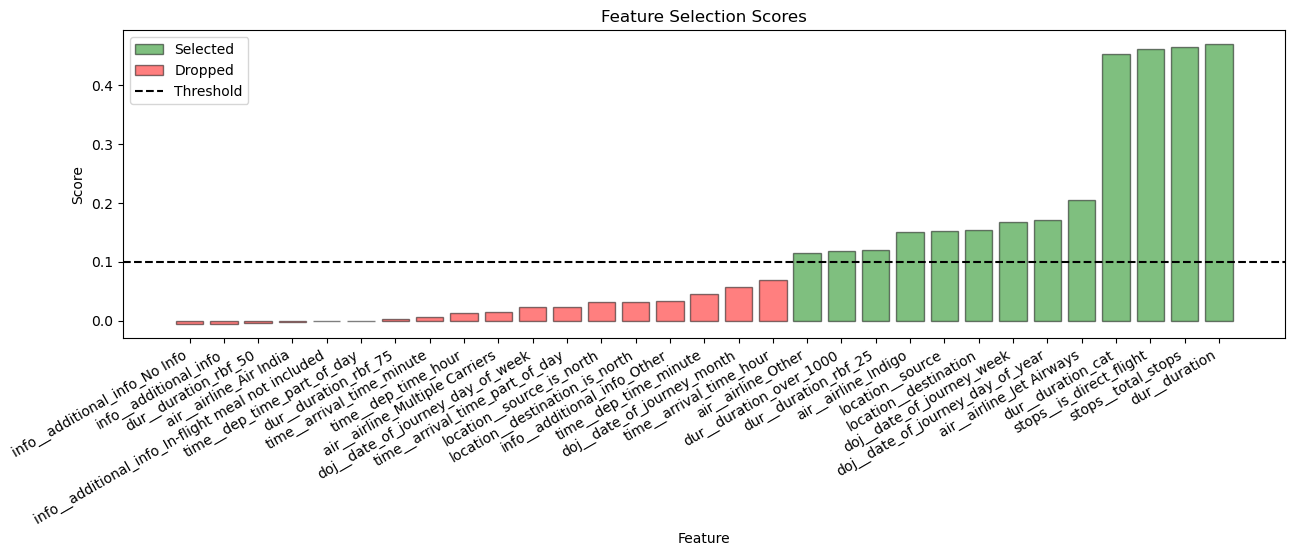

In [46]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

In [47]:
# The dataset went upto 31 columns after Feature Engineering
# The Feature Selection algorithm selected 13 features out of that